# Figures for DSTRF Paper

## Setup

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import yaml

from dstrf import strf, mle, io, performance, spikes
import mat_neuron._model as mat

# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
from analysis_fns import load_emdat, load_mldat, make_mlob

figroot = "/home/tyler/dstrf_results/figures/"
savefigs = False

yfile = "../../scripts/modeldata.yml"
with open(yfile,"r") as yf:
    config = yaml.load(yf)

# set variables based on `config`
ntaus = len(config["mat"]["taus"])
mat_fixed = np.asanyarray(config["mat"]["taus"] + [config["mat"]["refract"]],dtype='d')
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])
kcosbas = strf.cosbasis(config["strf"]["ntau"], config["strf"]["ntbas"])
ntbas = kcosbas.shape[1]
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])

In [2]:
%%time
# load data
select = ["posp","tonic", "phasic"]
data = {}

for s in select:
    res, mp = load_emdat(s,EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/modeldata/')
    data[s] = {"results": res,
               "map": mp}

CPU times: user 192 ms, sys: 276 ms, total: 468 ms
Wall time: 2.3 s


## 1: Concept figure
- biophysical model: piping song through RF and biophysics to generate spike trains
- phenomenological model: estimating RF and linear history terms + model 
- prediction of response
- How the model works?
- Side-by-side start with generative model
- Receptive field sub for dendritic tree, spike generation part, mapped onto little neuron cartoon
- Could even be a real example. 

## 2: Estimated vs true
- rows: same RF, different dynamics (posp, tonic, phasic)
- columns: same dynamics, different RFs (broadband fast, broadband slow, narrowband)
- show true RF, estimated RF, true spike trains, predicted spike trains.
- Quantify posterior overlap of RFs vs parameter estimates?
- In bottom row, show estimated w/a1/a2 values with posteriors for parameter estimates - corner plot or just a1 vs a2
- Pick out good exemplars 
- Grid RF in columns, posp/tonic/phasic in rows
- Show true and estimated RF
- RFs: broadband fast, broadband slow, narrow band

In [3]:
rootstr = "/scratch/dmeliza/modeldata/SNR4posp-norm/{}/rf.npz"
cell_data = {}
cell_nums = [4,12,24]
models = ["posp","tonic","phasic"]

def model_cell_str(m,n):
    s = "{}-rs-{}" if m == "posp" else "b-{}-{}"
    c = s.format(m,n)
    return c

def get_results(m,n):
    cell = model_cell_str(m,n)
    w1 = data[m]["results"][cell]["w1"]
    chain = data[m]["results"][cell]["chain"][-500:,:]
    mlest, mltest, adata, tdata = make_mlob(cell)
    est_rf = strf.from_basis(mltest.strf(w1),kcosbas)
    results =        { "w1": w1,
                        "chain": chain,
                        "mlest": mlest,
                        "mltest": mltest,
                        "est_rf": est_rf,
                        "assim_data": adata,
                        "test_data": tdata
                      }              
    return results

for m in models:
    for n in cell_nums:
        cell = model_cell_str(m,n)
        cell_data[cell] = get_results(m,n)

In [5]:
hm_cmap = "RdBu_r"

sns.set_style("ticks")
sns.set_context("notebook")

data_clr = "black"
est_clr = ["darkcyan","darkmagenta","goldenrod"]

def ticks_off():
    xticks([])
    yticks([])

def get_as(model,nums):
    a1 = []
    a2 = []
    for n in nums:
        cell= model_cell_str(model,n)
        a1.append(cell_data[cell]["chain"][-500:,1])
        a2.append(cell_data[cell]["chain"][-500:,2])
    return a1, a2


def despine(ax,x=True,y=True):     
    if x:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
   
    if y:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


In [6]:
cell_data.keys()

dict_keys(['b-phasic-24', 'b-phasic-4', 'b-tonic-12', 'b-tonic-4', 'b-phasic-12', 'b-tonic-24', 'posp-rs-24', 'posp-rs-4', 'posp-rs-12'])

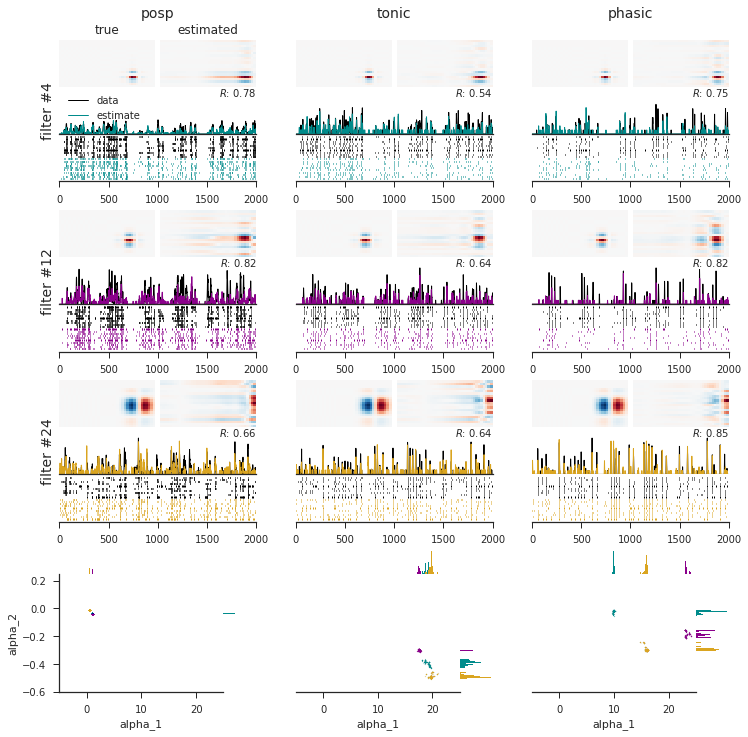

In [7]:
from matplotlib import gridspec

duration = 2000
fig = figure(2, figsize=(12, 12))
outer = gridspec.GridSpec(4, 3, wspace=0.2, hspace=0.2)

for i, m in enumerate(models):
    for j, n in enumerate(cell_nums):
        inner = gridspec.GridSpecFromSubplotSpec(3, 2,
                    subplot_spec=outer[i+3*j], wspace=0.05, hspace=0,height_ratios=[1,1,1])
    
        cell = model_cell_str(m,n)

        # plot true rf
        true_rf_plt = inner.new_subplotspec((0,0))
        ax = subplot(true_rf_plt)
        true_rf = np.load(rootstr.format(cell))["rf"]
        rsmpl_rf = np.fliplr(sp.signal.resample(sp.signal.resample(true_rf,20),40,axis=1))
        rsmpl_rf = np.vstack((np.zeros((3,40)), rsmpl_rf[:-3,:]))
        sns.heatmap(rsmpl_rf,cbar=False,cmap=hm_cmap,ax=ax)
        axis("off")

        if i+j == 0: ax.set_title("true")
       # if j == 0: 
       #     t = ax.text(0,0,m)
       #     t.set_ha('center')
       #     t.set_va('top')

        fig.add_subplot(ax)

        # plot estimated rf
        est_rf_plt = inner.new_subplotspec((0,1))
        ax = subplot(est_rf_plt)
        sns.heatmap(cell_data[cell]["est_rf"],cbar=False,cmap=hm_cmap,ax=ax)
        ticks_off()
        if i+j == 0: ax.set_title("estimated")
        axis("off")
        fig.add_subplot(ax)

        # plot spike rasters
        spikes_plt = inner.new_subplotspec((2,0),colspan=2)
        n_ppost = 10
        samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
        mltest = cell_data[cell]["mltest"]
        test_data = cell_data[cell]["test_data"]
        w1 = cell_data[cell]["w1"]
        chain = cell_data[cell]["chain"]

        spk_plt = inner.new_subplotspec((2,0),colspan=2)
        ax = subplot(spk_plt)

        all_spks = []
        for k, idx in enumerate(samples):
            mparam = chain[idx]
            V_mc = mltest.V(mparam)
            spk = mltest.predict(mparam,mat_fixed,V_mc)
            spk_t = spk.nonzero()[0]
            ax.vlines(spk_t * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                   k, k + 0.5,linewidth=1,color=est_clr[j])
            all_spks.append(spk)

        for l, spk in enumerate(test_data["spike_t"]):
            ax.vlines(spk * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                    l + k + 1, l + k + 1.5, data_clr,linewidth=1)
        ax.set_yticks([])
        ax.set_xlim(0,duration)
        sns.despine(left=True)  
        fig.add_subplot(ax)

        # plot psths
        spk_plt = inner.new_subplotspec((1,0),colspan=2)
        ax = subplot(spk_plt)
        psth = spikes.psth(np.asarray(all_spks).T,upsample,1)
        test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
        mx = np.max([psth,test_psth])
        ax.plot(test_psth/mx,linewidth=1,color=data_clr,label="data")
        ax.plot(psth/mx,linewidth=1,color=est_clr[j],label="estimate")
        eo = data[m]["results"][cell]["corr"].tolist() / data[m]["results"][cell]["eo"].tolist()
        #plot([],[],' ',label="$R$: {:.2f}".format(eo))
        if i+j == 0: ax.legend(["data","estimate"],loc="upper left")
        t = ax.text(duration,1.04,"$R$: {:.2f}".format(eo),fontsize=10)
        t.set_ha("right")
        ax.set_xlim(0,duration)
        ax.set_ylim(0,1.3)

        if i == 0: 
            ax.set_ylabel("filter #{}".format(n),fontsize=14)
        if j == 0:
            t = ax.text(duration/2,3.2,m,fontsize=14)
            t.set_ha("center")
            
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        fig.add_subplot(ax)

for i, m in enumerate(models):    
    a1, a2 = get_as(m, cell_nums)
    bottom = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i+9], wspace=0, hspace=0,
                                              height_ratios=[0.2,1],
                                              width_ratios=[1,0.2])
    ax = subplot(bottom[0])
    for j in range(3):
        ax.hist(a1[j],bins=10,color=est_clr[j])
    ax.set_xlim(mrange[0][1])
    ax.axis("off")

    ax = subplot(bottom[3])
    for j in range(3):
        ax.hist(a2[j],bins=10,orientation="horizontal",color=est_clr[j])
    ax.set_ylim(mrange[0][2])
    ax.axis("off")

    ax = subplot(bottom[2])
    for j in range(3):
        ax.scatter(a1[j],a2[j],alpha=0.1,s=1,color=est_clr[j])
    ax.set_xlabel("alpha_1")
    ax.set_xlim(mrange[0][1])
        
    if i==0: 
        ax.set_ylabel("alpha_2")
    else:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(mrange[0][2])
    ax.tick_params(top="off")
    
if savefigs: savefig(figroot+"fig2_modeldata_exmaples.pdf")

## 3: Population distribution
- corner plot of parameters
- panel showing adjusted R for three different dynamics
- possibly show how omega varies with RF parameters
- Maybe add panel with adjusted R, establish that it works
- See if we can figure out the souce of varation in omega, add another subplot

In [ ]:
def crnplt(data,label="",hist=True,mrange=None,labs=[r'$\omega$',r'$\alpha_1$',r'$\alpha_2$'],bins=None,kde_kws=None):
    for i in range(3):
        for j in range(3):
            if j > i: break
            subplot(3,3,3*i+j+1)

            if i == j:
                sns.distplot(data[:,j],hist=hist,label=label,bins=bins,kde_kws=kde_kws)
                if mrange:
                    xlim(mrange[0][i])
                if i == 0 and j == 0: legend()
                else: legend().set_visible(False)
            
            else:
                plot(data[:,j],data[:,i],'.',alpha=0.5,markersize=10)
                
                if mrange:
                    xlim(mrange[0][j])
                    ylim(mrange[0][i])
            
                
            xticks(rotation=45)    
            if 3*i+j == 3: ylabel(labs[1]);
            if 3*i+j == 6: ylabel(labs[2])
            if 3*i+j == 0: ylabel(labs[0])
            if 3*i+j == 7: xlabel(labs[1])
            if 3*i+j == 8: xlabel(labs[2])
            if 3*i+j == 6: xlabel(labs[0])
                
    
    sns.despine()
    tight_layout()
 

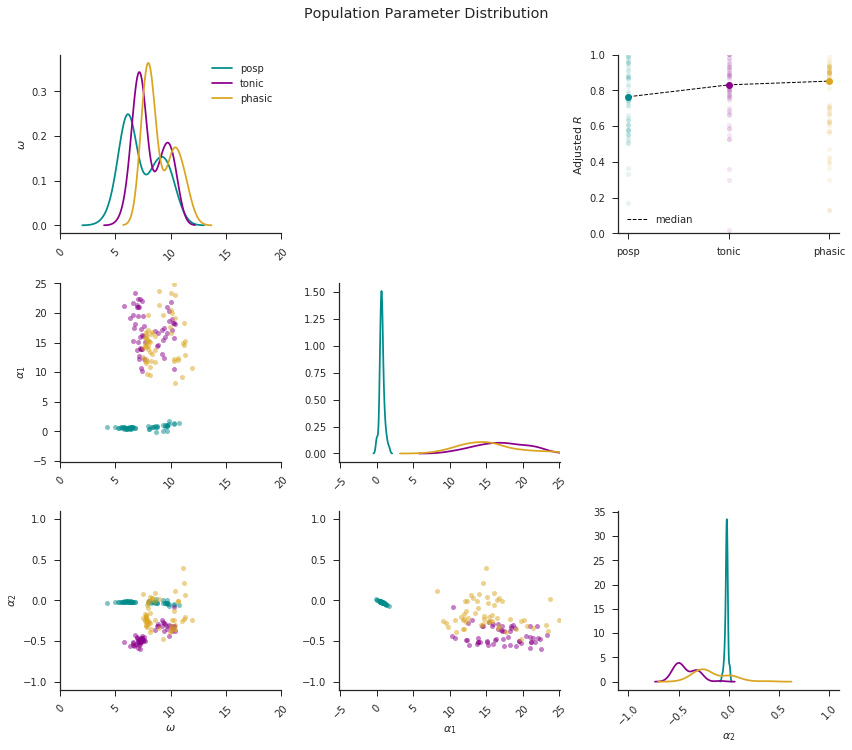

In [156]:
fig = figure(3, figsize=(12, 10))
   
# make corner plot
sns.set_style("ticks")
#sns.set_palette("cubehelix",len(select))
sns.set_palette(est_clr)

matlabs =  [r'$\omega$',r'$\alpha_1$',r'$\alpha_2$']

mrange=[[  0  , 20  ],
        [-5.1, 25.1],
        [ -1.1,  1.1]],

slimrange=[[  0  , 10  ],
           [-2.6, 2.6],
           [ -0.51,  0.51]],

HIST = False

for s in select:
    crnplt(data[s]["map"],s,mrange=mrange,labs=matlabs,hist=HIST)

suptitle("Population Parameter Distribution",y=1.04)


subplot(333)
meds = []
for i,s in enumerate(select):
    eo = [data[s]["results"][m]["corr"] / data[s]["results"][m]["eo"].tolist() for m in data[s]["results"]]
    plot([i]*len(eo),eo,"o",alpha=0.1,markersize=5)
    meds.append(np.median(eo))
plot(meds,"--k",label="median",linewidth=1)
for i,m in enumerate(meds):
    plot([i],[m],"o")
ylim(0,1)
ylabel("Adjusted $R$")
xticks([0,1,2],select)
sns.despine()
legend()

if savefigs: savefig(figroot+"fig3_modeldata_corner.pdf")

In [9]:
grtr = []
lss = []
m = "posp"
for cell in data[m]["results"]:
    w1 = data[m]["results"][cell]["w1"]
    try:
        result = get_results(m,cell.split("-")[-1])
        if w1[0] > 9:
            grtr.append([cell,w1,result["est_rf"]])
        
        elif w1[0] < 7:
            lss.append([cell,w1,result["est_rf"]])

    except:
        print("error loading {}".format(cell))

error loading posp-rs-57
error loading posp-rs-59


## 4: Example(s) of crcns
- one or two examples, from different brain regions, with good fit
- adapt the structure of Figure 1

In [60]:
cmresem["oo1920_9_B"]["corr"]/cmresem["oo1920_9_B"]["eo"]

0.91216891357370189

In [53]:
cmresem, cmmpem = load_emdat("cm",EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/crcns/')
cmresml, cmmpml = load_mldat("cm",EOcut=0.2,CORcut=0.2,root='/home/tyler/dstrf_results/crcns/')

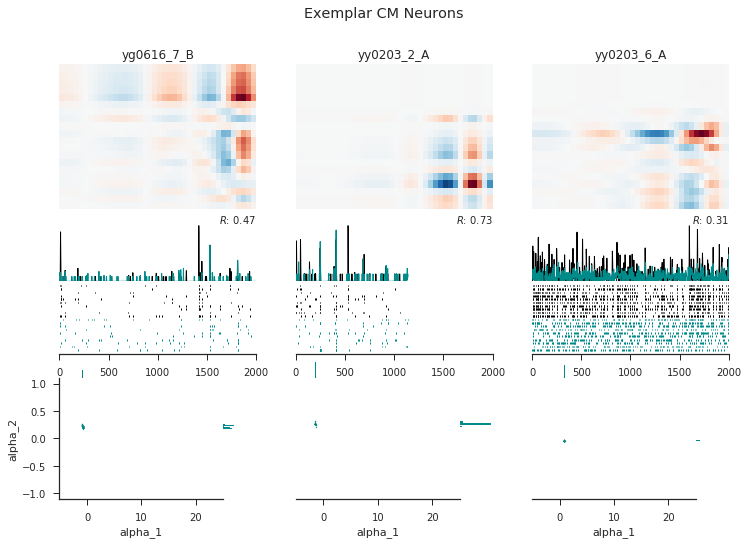

In [591]:
cm_select = ['yg0616_7_B','yy0203_2_A', 'yy0203_6_A']
fig = figure(4, figsize=(12, 8))
grid = gridspec.GridSpec(4, 3, wspace=0.2, hspace=0, height_ratios=[1,0.5,0.5,1])
for i,c in enumerate(cm_select):
    
    # strf estimate
    ax = subplot(grid[i])
    sns.heatmap(cmresem[c]["rf_map"],cbar=False,cmap=hm_cmap,ax=ax)
    ticks_off()
    ax.set_title(c)
    #if i == 0: ax.set_ylabel("estimated strf")
    #axis("off")
    fig.add_subplot(ax)

    # plot spike rasters
    ax = subplot(grid[i+6])
    n_ppost = 10
    samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
    mltest = cmresml[c]["mltest"]
    test_data = cmresml[c]["test_data"]
    w1 = cmresem[c]["w1"]
    chain = cmresem[c]["chain"]

    all_spks = []
    for k, idx in enumerate(samples):
        mparam = chain[idx]
        V_mc = mltest.V(mparam)
        spk = mltest.predict(mparam,mat_fixed,V_mc)
        spk_t = spk.nonzero()[0]
        ax.vlines(spk_t * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
               k, k + 0.5,linewidth=1,color=est_clr[0])
        all_spks.append(spk)  
        
    for l, spk in enumerate(test_data["spike_t"]):
        ax.vlines(spk * config["mat"]["model_dt"] / config["strf"]["stim_dt"],
                l + k + 1, l + k + 1.5, data_clr,linewidth=1)
    ax.set_yticks([])
    ax.set_xlim(0,duration)
        
    despine(ax,x=False)
    fig.add_subplot(ax)

    # plot psths
    ax = subplot(grid[i+3])
    psth = spikes.psth(np.asarray(all_spks).T,upsample,1)
    test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
    mx = np.max([psth,test_psth])
    ax.plot(test_psth/mx,linewidth=1,color=data_clr,label="data")
    ax.plot(psth/mx,linewidth=1,color=est_clr[0],label="estimate")
    eo = cmresem[c]["corr"].tolist() /  cmresem[c]["eo"].tolist()
    #plot([],[],' ',label="$R$: {:.2f}".format(eo))
    if i+j == 0: ax.legend(["data","estimate"],loc="upper left")
    t = ax.text(duration,1.04,"$R$: {:.2f}".format(eo),fontsize=10)
    t.set_ha("right")
    ax.set_xlim(0,duration)
    ax.set_ylim(0,1.3)
    despine(ax)
    fig.add_subplot(ax)
    

    bottom = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=grid[i+9], wspace=0, hspace=0,
                                              height_ratios=[0.2,1],
                                              width_ratios=[1,0.2])
    ax = subplot(bottom[0])
    a1 = cmresem[c]["chain"][-500:,1]
    a2 = cmresem[c]["chain"][-500:,2]

    ax.hist(a1,bins=10,color=est_clr[0])
    ax.set_xlim(mrange[0][1])
    ax.axis("off")

    ax = subplot(bottom[3])
    ax.hist(a2,bins=10,orientation="horizontal",color=est_clr[0])
    ax.set_ylim(mrange[0][2])
    ax.axis("off")

    ax = subplot(bottom[2])
    ax.scatter(a1,a2,alpha=0.1,s=1,color=est_clr[0])
    ax.set_xlabel("alpha_1")
    ax.set_xlim(mrange[0][1])
        
    if i==0: 
        ax.set_ylabel("alpha_2")
    else:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(mrange[0][2])
    ax.tick_params(top="off")

suptitle("Exemplar CM Neurons")

## 5: Crcns corner plot
- Show CM corner
- Point is to show that there is a bimodal distribution in CM

In [95]:
grtr = []
lssr = []
for c in cmmpem:
    if c[-1] > 0: grtr.append(c[-1])
    else: lssr.append(c[-1])

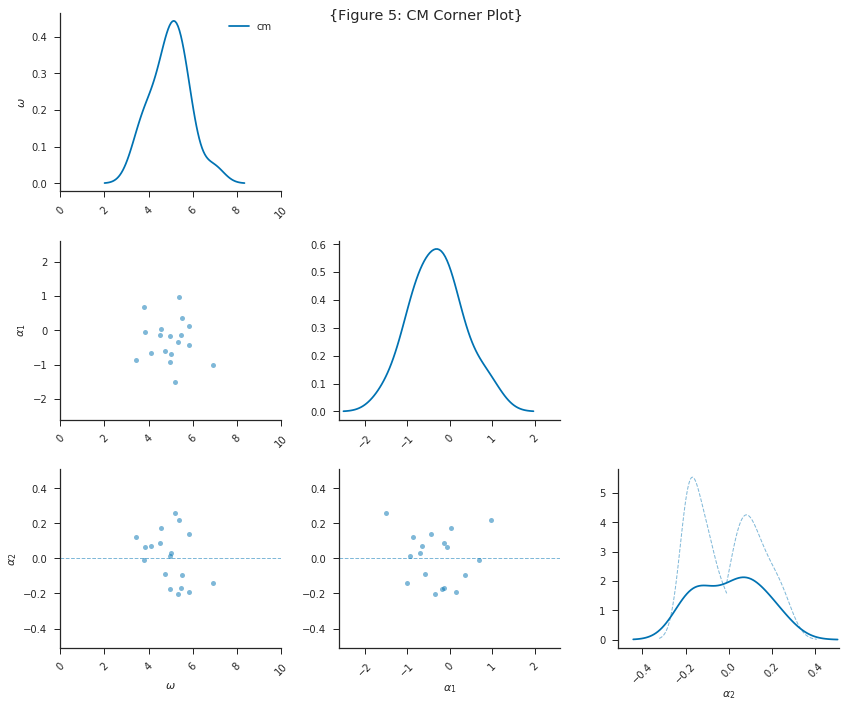

In [458]:
fig5 = figure(5, figsize=(12, 10))

clrs = sns.color_palette("colorblind")
zalpha=0.5
zlw=1

sns.set_palette(clrs)
crnplt(cmmpem,'cm',mrange=slimrange,labs=matlabs,hist=HIST)
subplot(337)
axhline(0,linestyle="--",alpha=zalpha,color=clrs[0],linewidth=zlw)
subplot(338)
axhline(0,linestyle="--",alpha=zalpha,color=clrs[0],linewidth=zlw)
subplot(339)
sns.kdeplot(np.asarray(grtr),linestyle="--",alpha=zalpha,color=clrs[0],clip=(-0.01,10),linewidth=zlw)
sns.kdeplot(np.asarray(lssr),linestyle="--",alpha=zalpha,color=clrs[0],clip=(-10,-0.01),linewidth=zlw)

suptitle("{Figure 5: CM Corner Plot}")
#sns.kdeplot(cmmpem[:,-1],bw=0.2)

In [54]:
i = 0
j=0
for c in cmmpem:
    if c[-1] > 0: i+=1
    else: j+=1

In [55]:
i,j

(10, 8)

## 6: Bulk Data
- May want to look into contours
- Could also just show a subset of the areas
- will need to figure out how to present data from so many areas effectively
- needs adjusted R^2 for each area
- ANOVA plot (Dan will do that)

In [601]:
%%time
# load data
select = ["mld", "ov", "l2a", "l2b", "l1", "cm", "l3"]
crdata = {}

for s in select:
    res, mp = load_emdat(s,EOcut=0.0,CORcut=0.0,root='/home/tyler/dstrf_results/crcns/')
    crdata[s] = {"results": res,
               "map": mp}

Error loading obla1305_6_EM-emcee
CPU times: user 340 ms, sys: 160 ms, total: 500 ms
Wall time: 665 ms


In [606]:
crdata[s]

{'map': array([[  5.60042523e+00,  -8.18835519e-03,  -8.28283754e-02],
        [  6.97975883e+00,  -3.48676708e-01,  -2.17270296e-01],
        [  6.57781886e+00,   1.49726279e-01,  -1.91803891e-01],
        [  6.33530306e+00,  -4.36629691e-01,  -1.37391307e-01],
        [  6.58571957e+00,   9.57183841e-01,  -3.96061845e-01],
        [  7.64114628e+00,  -1.94806455e-01,  -7.93179035e-02],
        [  5.94016473e+00,   1.69267250e-01,  -3.20626788e-03],
        [  7.69972101e+00,   3.08289170e-01,  -1.48153187e-03],
        [  6.02547110e+00,   1.41057251e-01,  -6.89068037e-02],
        [  5.02831037e+00,  -2.47778641e-01,   5.92547149e-03],
        [  7.15428373e+00,   2.34861218e-01,  -8.99523413e-02],
        [  6.35176972e+00,   5.05538174e-03,  -2.39352678e-02],
        [  5.33535847e+00,   3.21212463e+00,  -6.14976879e-02],
        [  5.26973541e+00,  -6.84952177e-02,  -1.09993123e-01],
        [  6.34251371e+00,   6.46734296e-02,  -8.00755153e-02],
        [  4.66738631e+00,   1.68

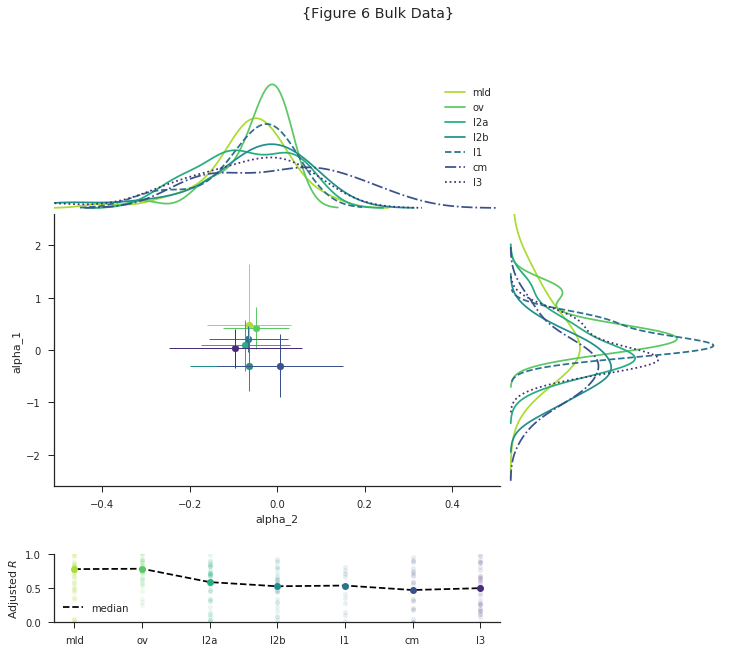

In [582]:
fig6 = figure(6, figsize=(12, 10))

pltselect = ["mld", "ov" , "l2a", "cm"]


gspec = gridspec.GridSpec(4, 2, wspace=0, hspace=0,
                                          height_ratios=[0.5,1,0.25,0.25],
                                          width_ratios=[1,0.5])
sns.set_palette("viridis_r",7)
lnstys = ["-"]*4 + ["--","-.",":"]
pntstys = ["o"]*7
for i,s in enumerate(select):
    #fig6 = figure(figsize=(12, 10))
    #gspec = gridspec.GridSpec(2, 2, wspace=0, hspace=0,height_ratios=[0.5,1],width_ratios=[1,0.5])
    ax = subplot(gspec[2])
    ax.scatter(np.mean(crdata[s]["map"][:,2]),np.mean(crdata[s]["map"][:,1]),alpha=1,label=s,marker=pntstys[i])
    ax.errorbar(np.mean(crdata[s]["map"][:,2]),np.mean(crdata[s]["map"][:,1]),
                xerr=np.std(crdata[s]["map"][:,2]),yerr=np.std(crdata[s]["map"][:,1]),linewidth=1)
    #ax.hexbin(crdata[s]["map"][:,2],crdata[s]["map"][:,1],alpha=1,label=s,extent=(-0.5,0.5,-3,3),gridsize=20,cmap=maps[i],zorder=0)
    ax.set_ylim(slimrange[0][1])
    ax.set_xlim(slimrange[0][2])
    despine(ax,x=False,y=False)
    ax.set_ylabel("alpha_1")
    ax.set_xlabel("alpha_2")

    ax = subplot(gspec[0])
    sns.kdeplot(crdata[s]["map"][:,2],label=s, linestyle=lnstys[i])
    despine(ax)
    ax.set_xlim(slimrange[0][2])
    legend()

    
    ax = subplot(gspec[3])
    sns.kdeplot(crdata[s]["map"][:,1],vertical=True, linestyle=lnstys[i])
    despine(ax)
    ax.set_ylim(slimrange[0][1])
    
    
ax = subplot(gspec[6])
meds = []
for i,s in enumerate(select):
    eo = [crdata[s]["results"][m]["corr"] / crdata[s]["results"][m]["eo"].tolist() for m in crdata[s]["results"]]
    ax.plot([i]*len(eo),eo,"o",alpha=0.1,markersize=5)
    meds.append(np.median(eo))
ax.plot(meds,"--k",label="median")
for i,m in enumerate(meds):
    ax.plot([i],[m],"o")
ax.set_ylim(0,1)
ax.set_ylabel("Adjusted $R$")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(select)
despine(ax,x=False,y=False)
legend()

suptitle("{Figure 6 Bulk Data}")

In [515]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': [],   
             'alpha': ((0.0, 0.0, 0.0),
               (0.3, 0.5, 0.5),
               (1.0, 1.0, 1.0))}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

import matplotlib.colors as mcolors

crgb = mcolors.ColorConverter().to_rgb
cyan_map = make_colormap([crgb('white'),crgb("c")])
magenta_map = make_colormap([crgb('white'),crgb("m")])
yellow_map = make_colormap([crgb('white'),crgb("y")])

cmyk_maps = [cyan_map,magenta_map,yellow_map]

cmyk = ["c","m","y","k"]

acmyk_maps = []
for cmap in maps:

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    #my_cmap[:int(cmap.N/3),-1] = 0

    # Create new colormap
    acmyk_maps.append(mcolors.ListedColormap(my_cmap))

In [610]:
import csv
savefile = "crcns_results.csv"
header = ["cell","region","w","a1","a2","corr","eo"]

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (110000, 110000))

with open(savefile,'w') as csvfile:
    writer =  csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for s in select:
        for k in crdata[s]["results"].keys():
            w1 = crdata[s]["results"][k]["w1"]
            corr = crdata[s]["results"][k]["corr"]
            eo = crdata[s]["results"][k]["eo"]
            writer.writerow([k,s,w1[0],w1[1],w1[2],corr,eo])
            
            
savefile = "modeldata_results.csv"
with open(savefile,'w') as csvfile:
    writer =  csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for s in models:
        for k in data[s]["results"].keys():
            w1 = data[s]["results"][k]["w1"]
            corr = data[s]["results"][k]["corr"]
            eo = data[s]["results"][k]["eo"]
            writer.writerow([k,s,w1[0],w1[1],w1[2],corr,eo])

In [609]:
savefile = "crcns_full_data.csv"
header = ["cell","region","w","a1","a2","corr","eo"]

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (110000, 110000))

